In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# PyTorch and Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim

# PIL for image handling
from PIL import Image
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and Extract Dataset
dataset_url = "https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz"
!wget $dataset_url -O CrisisMMD_v2.0.tar.gz

import tarfile
with tarfile.open("CrisisMMD_v2.0.tar.gz", "r:gz") as tar:
    tar.extractall("CrisisMMD_v2")


--2025-04-16 10:14:55--  https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz
Resolving crisisnlp.qcri.org (crisisnlp.qcri.org)... 37.186.61.208
Connecting to crisisnlp.qcri.org (crisisnlp.qcri.org)|37.186.61.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1902053684 (1.8G) [application/x-gzip]
Saving to: ‘CrisisMMD_v2.0.tar.gz’

CrisisMMD_v2.0.tar. 100%[===================>]   1.77G  11.5MB/s    in 3m 42s  

2025-04-16 10:18:38 (8.15 MB/s) - ‘CrisisMMD_v2.0.tar.gz’ saved [1902053684/1902053684]



In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Step 1: Unzip the dataset
zip_path = "/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all.zip"
extract_path = "/content/CrisisMMD_v2/CrisisMMD_v2.0"
os.makedirs(extract_path, exist_ok=True)

In [ ]:
# Extract only required files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if any(tsv in file for tsv in ["task_informative_text_img_train.tsv", "task_informative_text_img_test.tsv", "task_informative_text_img_dev.tsv"]):
            zip_ref.extract(file, extract_path)

print("TSV files extracted successfully!")

TSV files extracted successfully!


In [ ]:
# Step 2: Load the dataset
train_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_informative_text_img_train.tsv")
test_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_informative_text_img_test.tsv")
dev_file = os.path.join("/content/CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all/task_informative_text_img_dev.tsv")

train_data = pd.read_csv(train_file, sep="\t")
test_data = pd.read_csv(test_file, sep="\t")
dev_data = pd.read_csv(dev_file, sep="\t")


In [ ]:
# Combine data
data_df = pd.concat([train_data, test_data, dev_data], ignore_index=True)
print(f"Dataset loaded! Shape: {data_df.shape}")


Dataset loaded! Shape: (18082, 9)


In [ ]:
print(data_df.columns)

Index(['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label',
       'label_text', 'label_image', 'label_text_image'],
      dtype='object')


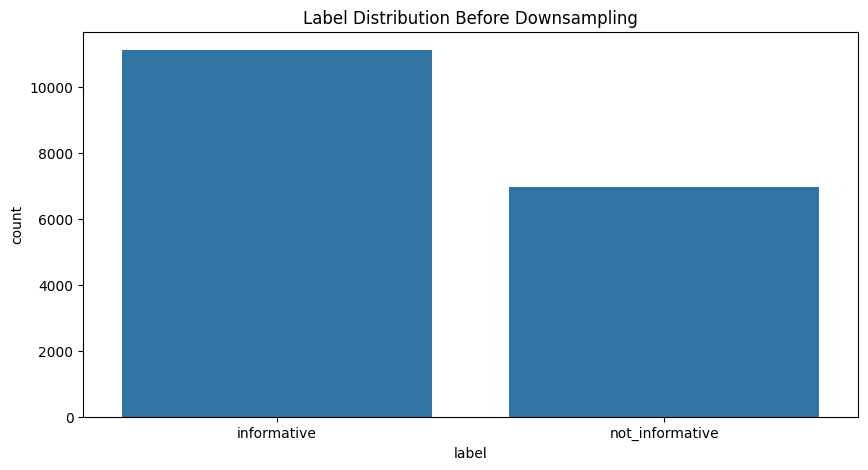

In [ ]:
# Check class distribution before downsampling
plt.figure(figsize=(10, 5))
sns.countplot(data=data_df, x="label", order=data_df["label"].value_counts().index)
plt.title("Label Distribution Before Downsampling")
plt.show()

In [ ]:
# Perform Data Balancing
majority_class = data_df[data_df['label'] == data_df['label'].value_counts().idxmax()]
minority_class = data_df[data_df['label'] != data_df['label'].value_counts().idxmax()]

minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
data_df = pd.concat([majority_class, minority_upsampled])

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
data_df["label_encoded"] = label_encoder.fit_transform(data_df["label"])


In [ ]:
# Print the mapping directly
print(label_encoder.classes_)

# Or, iterate and print for better readability
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}, Encoded Label: {i}")

['informative' 'not_informative']
Class: informative, Encoded Label: 0
Class: not_informative, Encoded Label: 1


In [ ]:
import joblib
import shutil

# Save the label encoder locally
label_encoder_path = 'label_encoder.pkl'
joblib.dump(label_encoder, label_encoder_path)

# Define Google Drive destination
drive_dir = '/content/drive/MyDrive/Multimodel'
os.makedirs(drive_dir, exist_ok=True)

# Copy to Google Drive
shutil.copy(label_encoder_path, drive_dir)


'/content/drive/MyDrive/Multimodel/label_encoder.pkl'

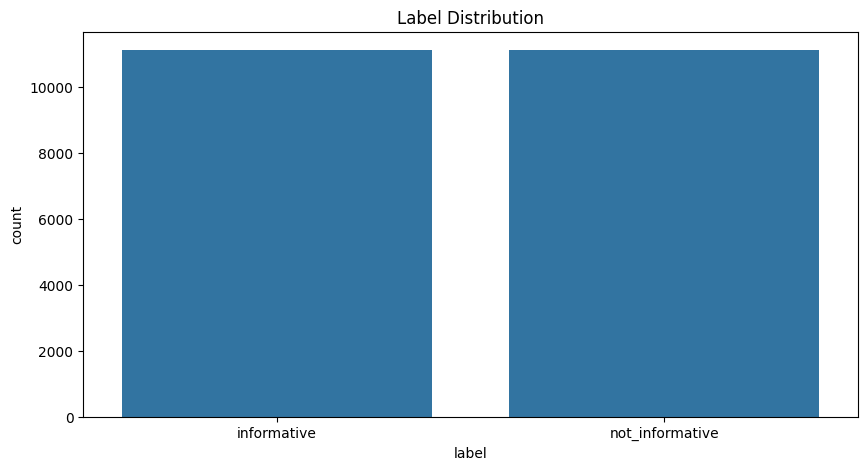

In [ ]:
# 2. Perform EDA
# Check label distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data_df, x="label", order=data_df["label"].value_counts().index)
plt.title("Label Distribution")
plt.show()


In [ ]:
# Text preprocessing
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def preprocess_text(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )

In [ ]:
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Custom Dataset Class
class CrisisDataset(Dataset):
    def __init__(self, df, tokenizer, transform, images_dir):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["tweet_text"]
        text_inputs = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors="pt")

        img_path = os.path.join(self.images_dir, row["image"])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        label = torch.tensor(row["label_encoded"], dtype=torch.long)
        return text_inputs, img, label

In [ ]:
# Custom Collate Function
def custom_collate_fn(batch):
    texts, images, labels = zip(*batch)
    input_ids = [text["input_ids"].squeeze(0) for text in texts]
    attention_masks = [text["attention_mask"].squeeze(0) for text in texts]

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)

    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return {"input_ids": input_ids_padded, "attention_mask": attention_masks_padded}, images, labels


In [ ]:
SEED = 42
train_data, val_data = train_test_split(data_df, test_size=0.2, stratify=data_df["label_encoded"], random_state=SEED)


In [ ]:
train_dataset = CrisisDataset(train_data, tokenizer, image_transform, extract_path)
val_dataset = CrisisDataset(val_data, tokenizer, image_transform, extract_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)


In [ ]:
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="microsoft/deberta-v3-base"):
        super(MultimodalModel, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for param in self.text_model.parameters():
            param.requires_grad = False  # Freeze all DeBERTa layers
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False  # Freeze all ResNet layers
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 256)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, text_inputs, images):
        text_outputs = self.text_model(**text_inputs)
        text_features = torch.mean(text_outputs.last_hidden_state, dim=1)
        text_features = self.text_fc(text_features)

        image_features = self.image_model(images)
        combined_features = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined_features)


In [ ]:
# Training Setup
model = MultimodalModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  1%|          | 1.12M/97.8M [00:00<00:09, 10.8MB/s]
  5%|▍         | 4.50M/97.8M [00:00<00:03, 24.6MB/s]
  7%|▋         | 7.12M/97.8M [00:00<00:03, 25.7MB/s]
 11%|█         | 10.9M/97.8M [00:00<00:0

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0  # Track best validation accuracy
    best_model_weights = None  # Store best model weights

    # Create directory for saving models if it doesn't exist
    os.makedirs('saved_models', exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train = 0, 0
        all_train_preds = []
        all_train_labels = []

        for text_inputs, images, labels in train_loader:
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_inputs, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()

            # Store predictions and labels for metrics
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct_val = 0, 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for text_inputs, images, labels in val_loader:
                text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
                images, labels = images.to(device), labels.to(device)

                outputs = model(text_inputs, images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()

                # Store predictions and labels for metrics
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate additional metrics
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }, f"saved_models/best_model_epoch_{epoch+1}.pth")
            print(f"New best model saved with val acc: {val_acc:.4f}")

    # Save the final model
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        'accuracy': val_acc
    }, "saved_models/final_model.pth")

    # Load best weights back into model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
# Training with best model saving
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=5
)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
Train - Loss: 0.5776, Acc: 0.7038, F1: 0.7037
Val   - Loss: 0.5727, Acc: 0.7020, F1: 0.6943
New best model saved with val acc: 0.7020


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/5
Train - Loss: 0.5454, Acc: 0.7279, F1: 0.7278
Val   - Loss: 0.5393, Acc: 0.7292, F1: 0.7269
New best model saved with val acc: 0.7292


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/5
Train - Loss: 0.5318, Acc: 0.7373, F1: 0.7372
Val   - Loss: 0.5168, Acc: 0.7561, F1: 0.7549
New best model saved with val acc: 0.7561


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/5
Train - Loss: 0.5196, Acc: 0.7443, F1: 0.7443
Val   - Loss: 0.5188, Acc: 0.7478, F1: 0.7467


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/5
Train - Loss: 0.5027, Acc: 0.7547, F1: 0.7547
Val   - Loss: 0.5202, Acc: 0.7426, F1: 0.7410


In [ ]:
# Save model state_dict
torch.save(model.state_dict(), "/content/drive/MyDrive/Multimodel/final_model_state_dict.pth")

# Save optimizer
torch.save(optimizer.state_dict(), "/content/drive/MyDrive/Multimodel/optimizer_state_dict.pth")

# Save label encoder
joblib.dump(label_encoder, "/content/drive/MyDrive/Multimodel/label_encoder.pkl")

# Save additional metadata
metadata = {
    "tokenizer": "microsoft/deberta-v3-base",
    "image_model": "resnet50",
    "num_classes": 2,
    "input_size": 224
}
import json
with open("/content/drive/MyDrive/Multimodel/metadata.json", "w") as f:
    json.dump(metadata, f)


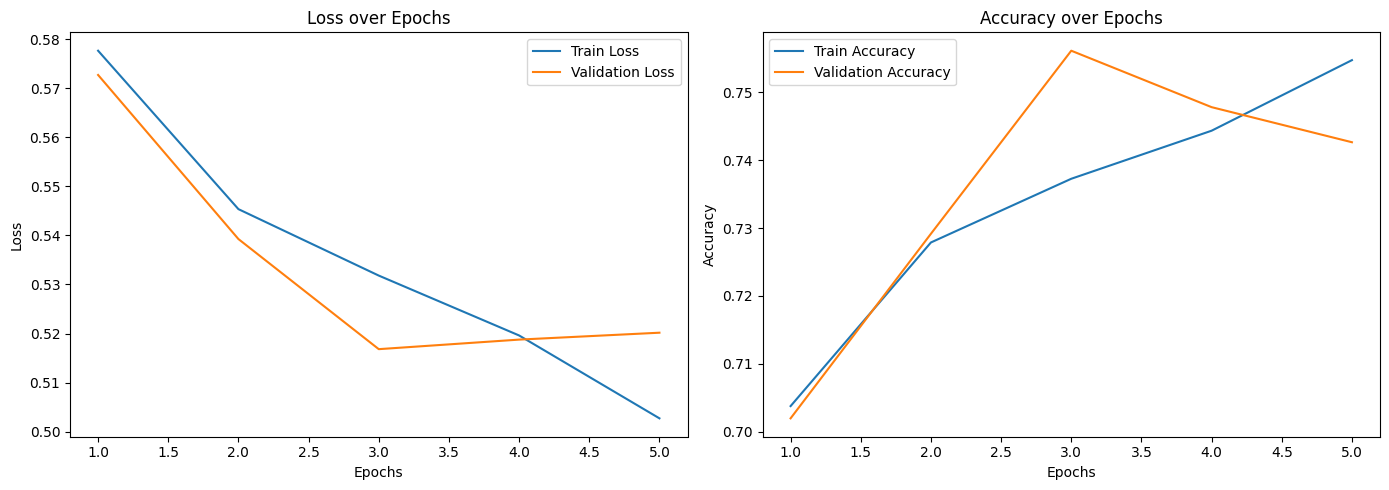

In [ ]:
# Plot Training and Validation Accuracy and Loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Classification Report:
                 precision    recall  f1-score   support

    informative       0.71      0.82      0.76      2225
not_informative       0.79      0.66      0.72      2224

       accuracy                           0.74      4449
      macro avg       0.75      0.74      0.74      4449
   weighted avg       0.75      0.74      0.74      4449

Confusion Matrix:


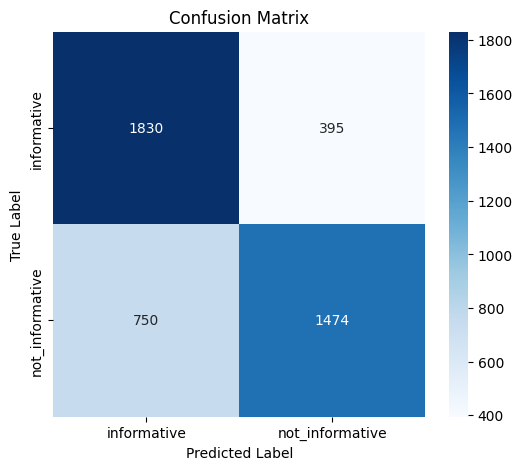

In [ ]:
# Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text_inputs, images, labels in data_loader:
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images, labels = images.to(device), labels.to(device)

            outputs = model(text_inputs, images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model
evaluate_model(model, val_loader)

# Testing part

In [ ]:
import os
import zipfile
import tarfile
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import joblib
import json

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Download and extract dataset
dataset_url = "https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz"
os.system(f"wget {dataset_url} -O CrisisMMD_v2.0.tar.gz")

with tarfile.open("CrisisMMD_v2.0.tar.gz", "r:gz") as tar:
    tar.extractall("CrisisMMD_v2")



EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
zip_path = "CrisisMMD_v2/CrisisMMD_v2.0/crisismmd_datasplit_all.zip"
extract_path = "CrisisMMD_v2/CrisisMMD_v2.0"


In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if "task_informative_text_img_test.tsv" in file:
            zip_ref.extract(file, extract_path)

test_file = os.path.join(extract_path, "crisismmd_datasplit_all/task_informative_text_img_test.tsv")
test_data = pd.read_csv(test_file, sep="\t")

In [ ]:
# Load metadata and label encoder
label_encoder = joblib.load("/content/drive/MyDrive/Multimodel/label_encoder.pkl")
with open("/content/drive/MyDrive/Multimodel/metadata.json") as f:
    metadata = json.load(f)

In [ ]:
# Transform labels
test_data["label_encoded"] = label_encoder.transform(test_data["label"])


In [ ]:
# Tokenizer and image transforms
tokenizer = AutoTokenizer.from_pretrained(metadata["tokenizer"])
image_transform = transforms.Compose([
    transforms.Resize((metadata["input_size"], metadata["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Dataset definition
class CrisisDataset(Dataset):
    def __init__(self, df, tokenizer, transform, images_dir):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text_inputs = self.tokenizer(row["tweet_text"], truncation=True, padding='max_length', max_length=128, return_tensors="pt")
        img_path = os.path.join(self.images_dir, row["image"])
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new("RGB", (224, 224))
        img = self.transform(img)
        label = torch.tensor(row["label_encoded"], dtype=torch.long)
        return text_inputs, img, label

def custom_collate_fn(batch):
    texts, images, labels = zip(*batch)
    input_ids = [text["input_ids"].squeeze(0) for text in texts]
    attention_masks = [text["attention_mask"].squeeze(0) for text in texts]

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return {"input_ids": input_ids_padded, "attention_mask": attention_masks_padded}, images, labels


In [ ]:
# Model class with frozen pretrained layers
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="microsoft/deberta-v3-base"):
        super(MultimodalModel, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        for param in self.text_model.parameters():
            param.requires_grad = False
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        self.image_model = models.resnet50(pretrained=True)
        for param in self.image_model.parameters():
            param.requires_grad = False
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 256)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, len(label_encoder.classes_))
        )

    def forward(self, text_inputs, images):
        text_outputs = self.text_model(**text_inputs)
        text_features = torch.mean(text_outputs.last_hidden_state, dim=1)
        text_features = self.text_fc(text_features)

        image_features = self.image_model(images)
        combined_features = torch.cat((text_features, image_features), dim=1)
        return self.classifier(combined_features)


In [ ]:
# Load the model and weights
model = MultimodalModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Multimodel/final_model_state_dict.pth", map_location=device))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultimodalModel(
  (text_model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [ ]:
# Dataloader
images_dir = extract_path
test_dataset = CrisisDataset(test_data, tokenizer, image_transform, images_dir)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Classification Report:
                 precision    recall  f1-score   support

    informative       0.79      0.84      0.81      1373
not_informative       0.72      0.63      0.67       864

       accuracy                           0.76      2237
      macro avg       0.75      0.74      0.74      2237
   weighted avg       0.76      0.76      0.76      2237



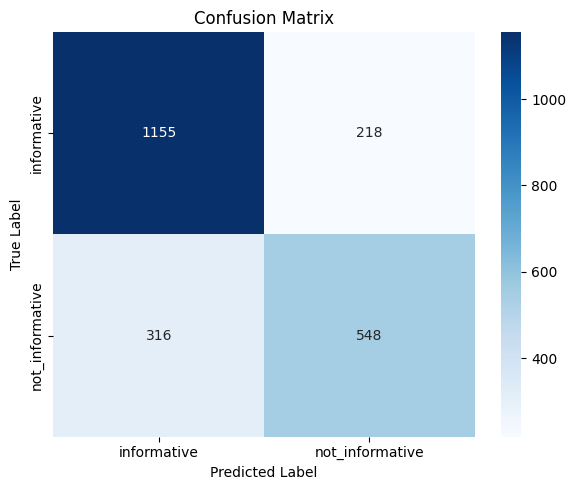

In [ ]:
# Evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for text_inputs, images, labels in test_loader:
        text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
        images, labels = images.to(device), labels.to(device)
        outputs = model(text_inputs, images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()